# Diagonal boundary with the 1st-order acoustic wave equation

Now we will move to a slightly more complex system of equations: the first-order formulation of the wave equation, formed from coupled system of velocity and pressure update equations.

We will begin by loading in the 45 degree surface. In this case, as we have staggered grids, we will need to load an SDF for each staggered grid. The grid to which each SDF pertains is deduced automatically from the SDF `Function`'s `staggered` attribute.

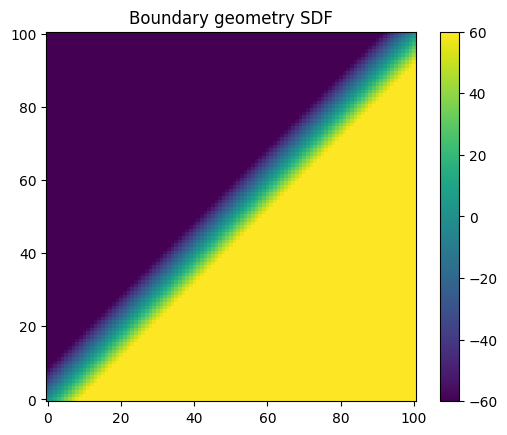

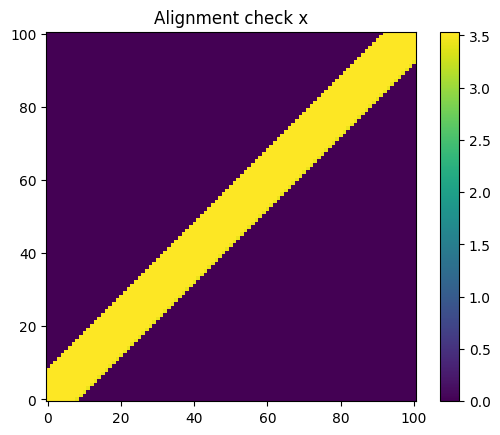

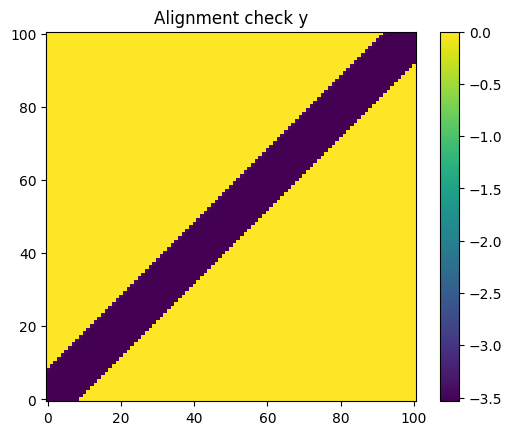

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the diagonal 2D sdf
sdf = read_sdf('45', 2)

# Load the staggered sdfs
sdf_x = read_sdf('45_x', 2)
sdf_y = read_sdf('45_y', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

# It is a good idea to make sure your signed distance functions are aligned
# Misaligned SDFs can result in considerable weirdness
plt.imshow(sdf_x.data.T-sdf.data.T, origin='lower')
plt.title("Alignment check x")
plt.colorbar()
plt.show()

plt.imshow(sdf_y.data.T-sdf.data.T, origin='lower')
plt.title("Alignment check y")
plt.colorbar()
plt.show()

We will provide all three SDFs to the `BoundaryGeometry`. If desired, the cutoff at which points are considered to be too close to the boundary can be modified by supplying an optional `cutoff` argument in the form `{origin: 0.5}`. The key is the origin of the subgrid, and the respective value is distance from the boundary in grid increments. If not supplied, it will default to half a grid increment.

In [2]:
from schism import BoundaryGeometry
import sympy as sp

x, y = sdf.grid.dimensions
h_x = x.spacing
h_y = y.spacing
zero = sp.core.numbers.Zero()
cutoff = {(h_x/2, zero): 0., (zero, h_y/2): 0.}

bg = BoundaryGeometry((sdf, sdf_x, sdf_y), cutoff=cutoff)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


In this case, we have pressure (a scalar quantity) and particle velocity (a vector quantity), so we should set up functions accordingly.

In [3]:
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o,
                    time_order=1, staggered=dv.NODE)
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=s_o,
                          time_order=1)

We will also have velocity free-surface boundary conditions in addition to the pressure ones. These take the form of the divergence of particle velocity (and laplacians thereof) equalling zero.

In [4]:
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),  # Zero pressure on free surface
           dv.Eq(p.dx2 + p.dy2, 0),  # Zero laplacian
           dv.Eq(p.dx4 + 2*p.dx2dy2 + p.dy4, 0),  # Zero biharmonic
           dv.Eq(v[0].dx + v[1].dy, 0),  # Divergence of velocity equals zero
           dv.Eq(v[0].dx3 + v[1].dx2dy
                 + v[0].dxdy2 + v[1].dy3, 0)]  # Laplacian of divergence is zero

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

The derivatives we will need in our equation are `p.dx`, `p.dy`, `v[0].dx`, and `v[1].dy`. Note that we will also need to specify the staggering of these derivatives, as staggered grids will be used.

In [6]:
x, y = grid.dimensions

pdx = p.dx(x0=x+x.spacing/2)
pdy = p.dy(x0=y+y.spacing/2)
vxdx = v[0].forward.dx(x0=x)
vydy = v[1].forward.dy(x0=y)

derivs = (pdx, pdy, vxdx, vydy)

subs = boundary.substitutions(derivs)

We will also need a damping mask and source term.

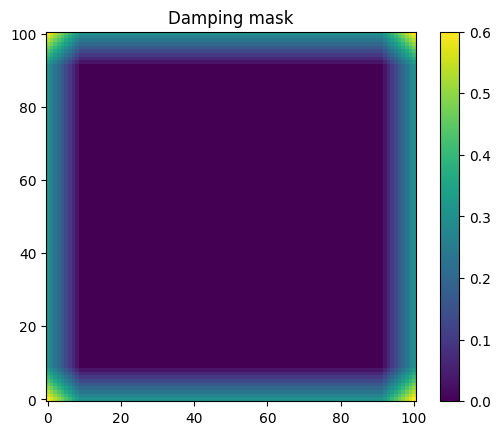

In [7]:
import numpy as np

damp = dv.Function(name='damp', grid=grid)

# Number of boundary layers
nbl = 10
taper = np.linspace(0, 0.3, nbl)

# Add the taper to the function's data
damp.data[:10] += taper[::-1, np.newaxis]
damp.data[-10:] += taper[:, np.newaxis]
damp.data[:, :10] += taper[np.newaxis, ::-1]
damp.data[:, -10:] += taper[np.newaxis, :]

plt.imshow(damp.data.T, origin='lower')
plt.title("Damping mask")
plt.colorbar()
plt.show()

In [8]:
from examples.seismic import TimeAxis, RickerSource

c = 1

t0 = 0.  # Simulation starts a t=0
tn = 550.  # Simulation last 0.55 seconds (550 ms)
dt = 0.5*10/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.010  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 600.
src.coordinates.data[0, 1] = 400.

print("Grid points per wavelength:", 1/(f0*grid.spacing[0]))

Grid points per wavelength: 10.0


And now for our update equations.

In [9]:
rho = 1
# Pressure update
eq_p = dv.Eq(p.forward, (1-damp)*(p + dt*rho*c**2*(subs[vxdx] + subs[vydy])))
# Velocity updates
eq_vx = dv.Eq(v[0].forward, v[0] + dt*subs[pdx]/rho)
eq_vy = dv.Eq(v[1].forward, v[1] + dt*subs[pdy]/rho)

In [10]:
src_term = src.inject(field=p.forward, expr=c*src*dt**2)

In [11]:
op = dv.Operator([eq_vx, eq_vy, eq_p] + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.29 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.282221, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=5.699999999999994e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

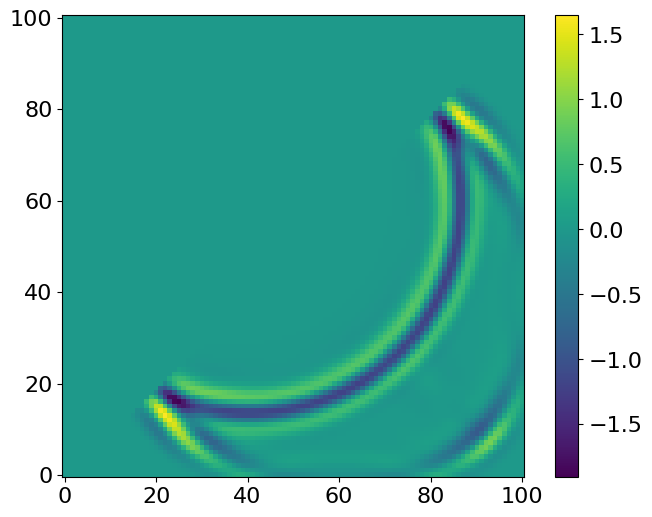

In [12]:
import sympy as sp

plt.imshow(p.data[1].T, origin='lower')
plt.colorbar()
plt.show()

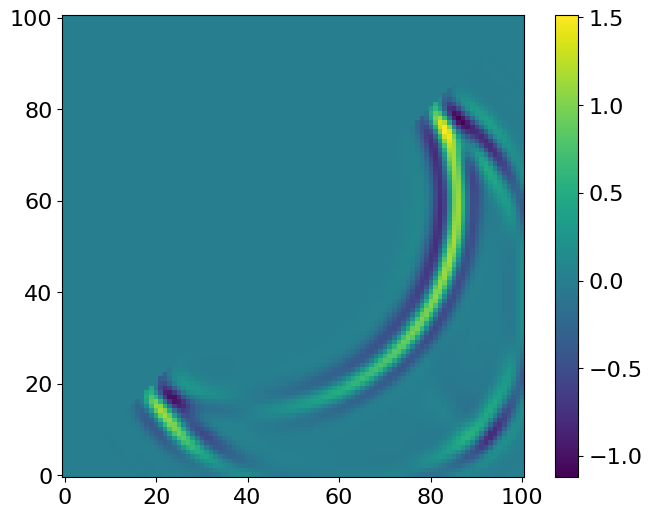

In [13]:
plt.imshow(v[0].data[1].T, origin='lower')
plt.colorbar()
plt.show()

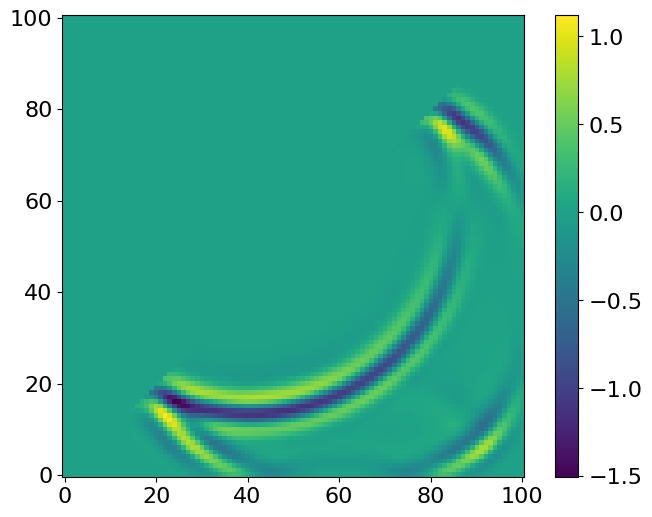

In [14]:
plt.imshow(v[1].data[1].T, origin='lower')
plt.colorbar()
plt.show()